In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 24kB/s 
     |████████████████████████████████| 4.1MB 55.8MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 276kB 4.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=8e516b60c6fa078e815ead1216ea3d4ec1197051947e33b525bfab81b62b2ffa
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [ ]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 5.9MB 1.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200611-cp36-none-any.whl size=41026 sha256=c4162b9add7abffe32048b8f69bb317854a61033e046a1b65a704a780152e8fb
  Stored in directory: /root/.cache/pip/wheels/d2/eb/15/e71cb12830acdedf55806d66c214157ed61702f8ae97273b56
Successfully built fvcore


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
import pandas as pd

df = pd.read_csv('drive/My Drive/images/train_labels.csv')

df.head()

filename  width  height           class  xmin  ymin  xmax  ymax
0    1.jpg    175     129  Traffic signal    15     4   119    93
1   10.jpg    187     129  Traffic signal    33     6   134    96
2   11.jpg    177     129  Traffic signal    37     1   142    92
3   12.jpg    168     129  Traffic signal    27     4   127    98
4   13.jpg    189     132  Traffic signal    62     5   159   102

In [ ]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

# write a function that loads the dataset into detectron2's standard format
def get_trafficsignals_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['filename'].map(lambda x: img_dir+x)

    classes = ['Traffic signal']

    df['class_int'] = df['class'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['Traffic signal']

for d in ["train", "test"]:
  DatasetCatalog.register('trafficsignals/' + d, lambda d=d: get_trafficsignals_dicts('drive/My Drive/images/' + d + '_labels.csv', 'drive/My Drive/images/' + d+'/'))
  MetadataCatalog.get('trafficsignals/' + d).set(thing_classes=classes)
trafficsignals_metadata = MetadataCatalog.get('trafficsignals/train')

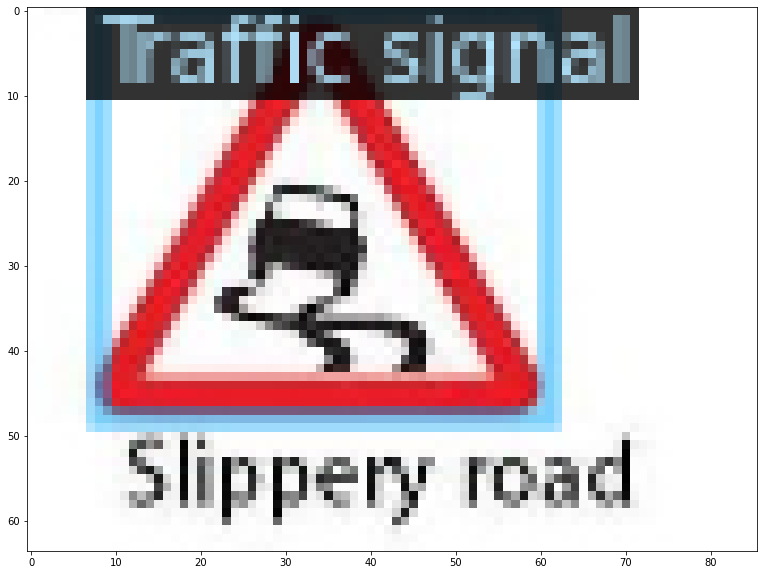

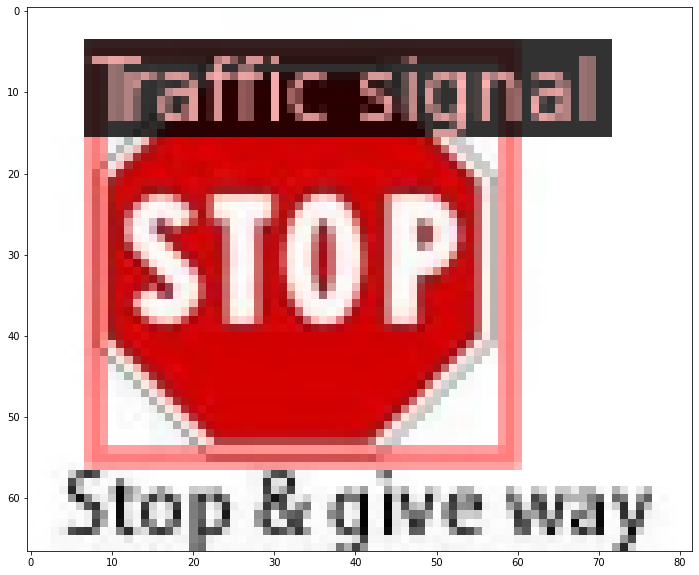

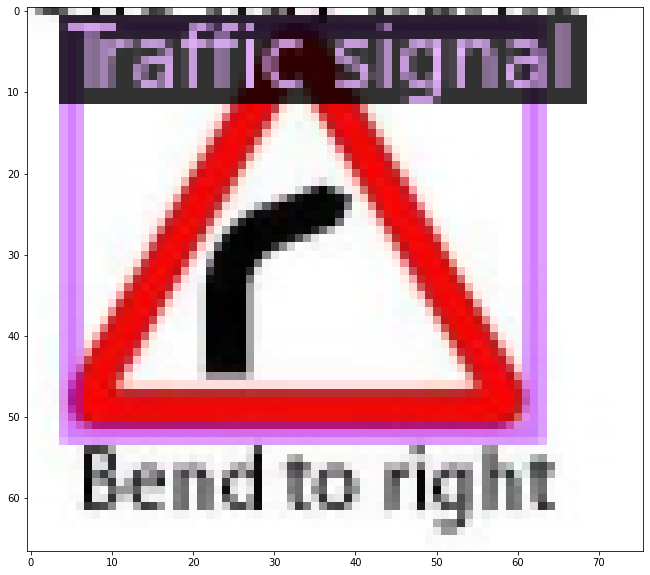

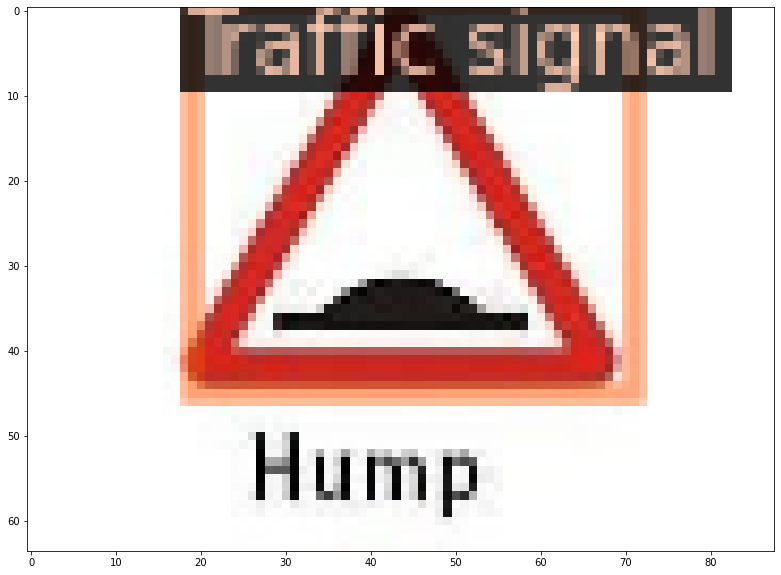

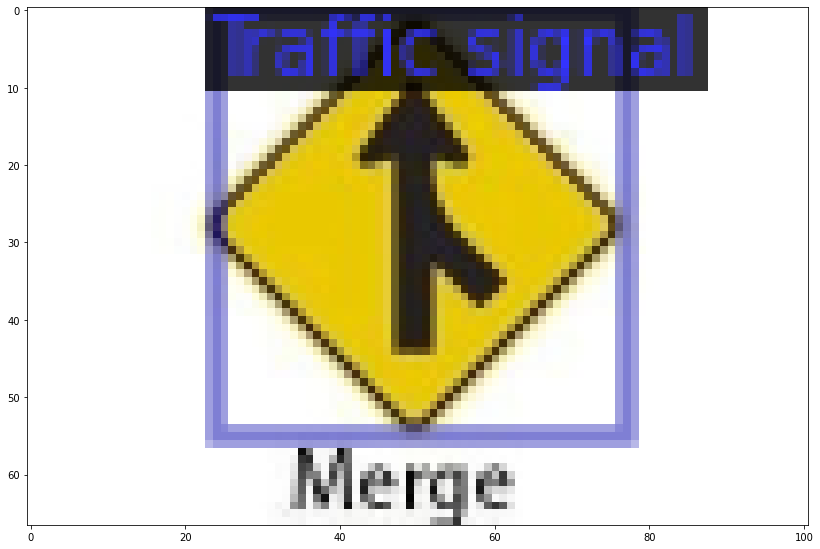

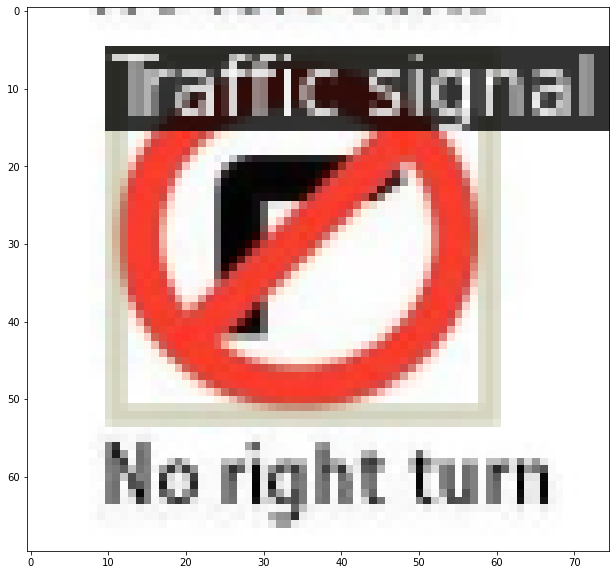

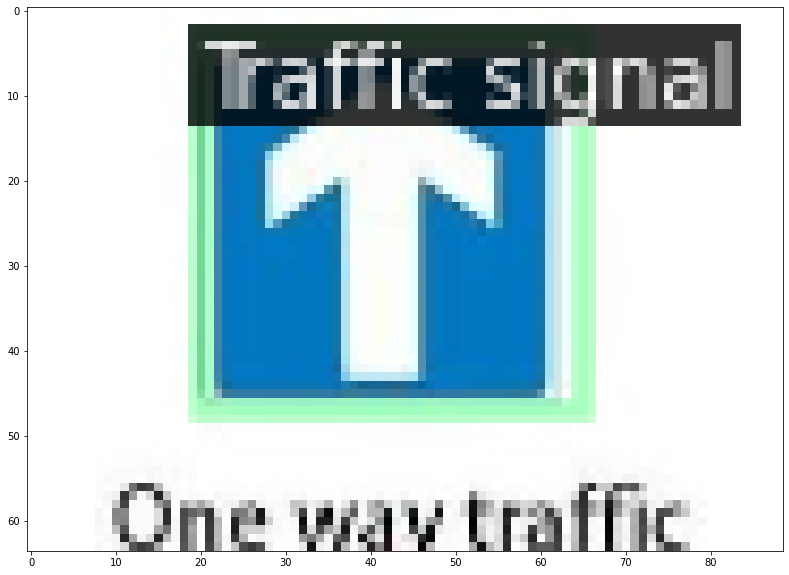

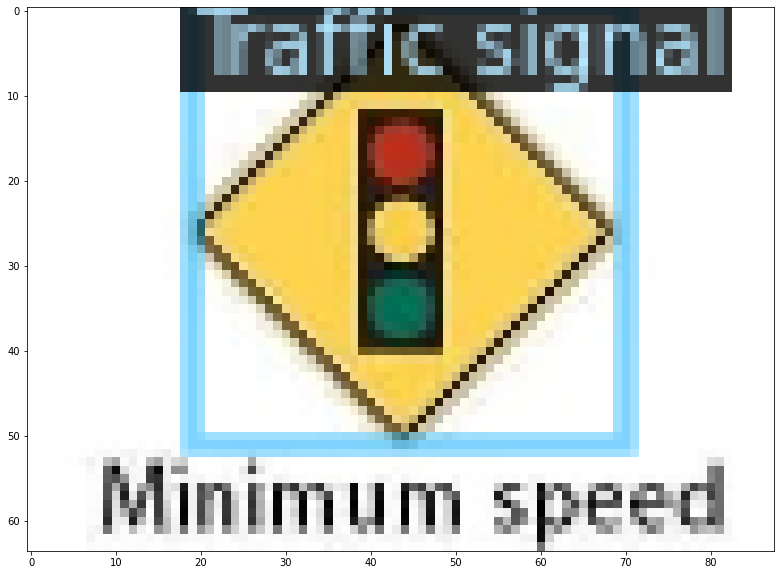

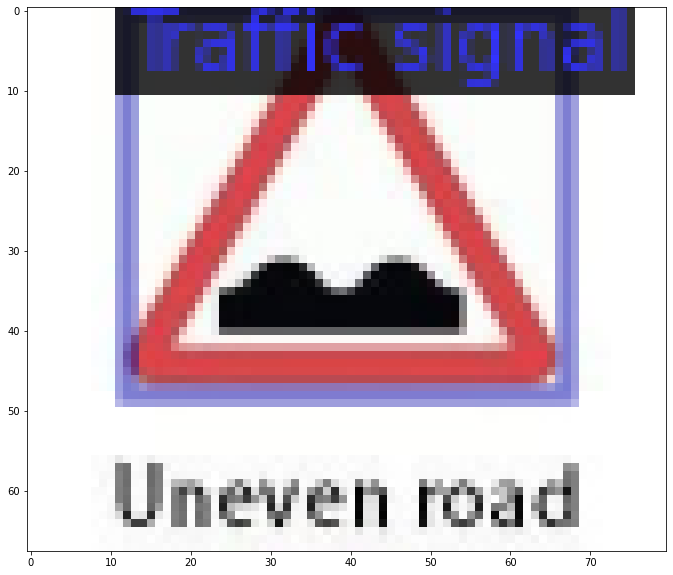

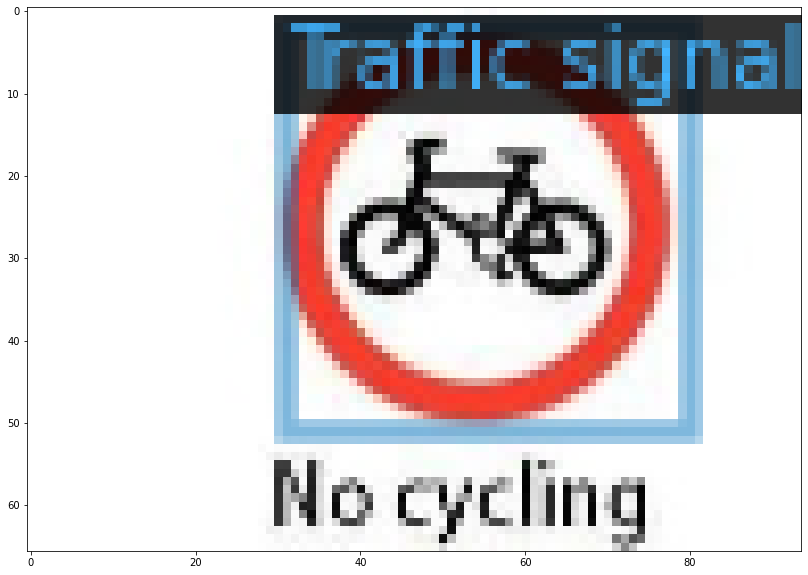

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('trafficsignals/train')
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=trafficsignals_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("trafficsignals/train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 250    # 250 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 2  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/11 10:22:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:11, 15.3MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


[06/11 10:22:44 d2.engine.train_loop]: Starting training from iteration 0
[06/11 10:22:49 d2.utils.events]:  eta: 0:00:56  iter: 19  total_loss: 0.527  loss_cls: 0.521  loss_box_reg: 0.000  loss_mask: 0.000  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  time: 0.2466  data_time: 0.0128  lr: 0.000005  max_mem: 2656M
[06/11 10:22:54 d2.utils.events]:  eta: 0:00:51  iter: 39  total_loss: 0.450  loss_cls: 0.444  loss_box_reg: 0.000  loss_mask: 0.000  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.2419  data_time: 0.0068  lr: 0.000010  max_mem: 2656M
[06/11 10:22:59 d2.utils.events]:  eta: 0:00:46  iter: 59  total_loss: 0.288  loss_cls: 0.282  loss_box_reg: 0.000  loss_mask: 0.000  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  time: 0.2405  data_time: 0.0061  lr: 0.000015  max_mem: 2656M
[06/11 10:23:03 d2.utils.events]:  eta: 0:00:40  iter: 79  total_loss: 0.180  loss_cls: 0.170  loss_box_reg: 0.000  loss_mask: 0.000  loss_rpn_cls: 0.002  loss_rpn_loc: 0.005  time: 0.2368  data_time: 0.0057  lr:

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ('trafficsignals/test', )
predictor = DefaultPredictor(cfg)

In [ ]:
df_test = pd.read_csv('drive/My Drive/images/test_labels.csv')
df_test

filename  width  height           class  xmin  ymin  xmax  ymax
0     1.jpg    168     249  Traffic signal    25     1   115    87
1     1.jpg    168     249  Traffic signal    21   128   116   217
2    10.jpg    357     135  Traffic signal    17     1   132   105
3    10.jpg    357     135  Traffic signal   213     3   320    98
4    11.jpg    354     137  Traffic signal    40     6   135   102
5    11.jpg    354     137  Traffic signal   216     1   319    99
6    12.jpg    166     191  Traffic signal    27     9   125   107
7    13.jpg    274     107  Traffic signal    44     6    96    57
8    13.jpg    274     107  Traffic signal   189     6   243    56
9    14.jpg    240     117  Traffic signal    16     6    77    60
10   14.jpg    240     117  Traffic signal   143     6   205    61
11   15.jpg    264     119  Traffic signal    29     3    92    59
12   15.jpg    264     119  Traffic signal   159     4   223    58
13   16.jpg    242     100  Traffic signal    19    17    83    71
14   16.jpg    242     100  Traffic signal   140    17   207    71
15   17.jpg    264      97  Traffic signal    27    13    90    71
16   17.jpg    264      97  Traffic signal   156    14   218    70
17   19.jpg    146     213  Traffic signal    47     7   111    63
18   19.jpg    146     213  Traffic signal    48   130   109   185
19    2.jpg    338     251  Traffic signal    12     1   110    93
20    2.jpg    338     251  Traffic signal   181     1   279    92
21    2.jpg    338     251  Traffic signal    11   124   108   214
22    2.jpg    338     251  Traffic signal   179   116   279   207
23   20.jpg    344     242  Traffic signal     4     3   158   156
24   20.jpg    344     242  Traffic signal   170     1   339   165
25   21.jpg    338     232  Traffic signal     4    26   155   177
26   21.jpg    338     232  Traffic signal   164    23   325   184
27   22.jpg    371     237  Traffic signal    18    27   188   188
28   22.jpg    371     237  Traffic signal   199    26   354   187
29   23.jpg    175     247  Traffic signal    12     1   175   165
30   24.jpg    115     143  Traffic signal    10    20    93   102
31   25.jpg    114     143  Traffic signal    21    18   107   100
32    3.jpg    335     136  Traffic signal     5    14   112   108
33    3.jpg    335     136  Traffic signal   205     8   305   106
34    4.jpg    321     153  Traffic signal    21    38   119   134
35    4.jpg    321     153  Traffic signal   217    32   321   126
36    5.jpg    352     122  Traffic signal    29     1   136    95
37    5.jpg    352     122  Traffic signal   231     1   327    94
38    6.jpg    344     263  Traffic signal    25     1   123    97
39    6.jpg    344     263  Traffic signal   225     1   322    96
40    6.jpg    344     263  Traffic signal    24   132   131   238
41    6.jpg    344     263  Traffic signal   224   127   333   221
42    7.jpg    479     130  Traffic signal    10    18   106   103
43    7.jpg    479     130  Traffic signal   186    15   280   106
44    7.jpg    479     130  Traffic signal   356    10   447    96
45    8.jpg    370     142  Traffic signal    33    11   142   109
46    8.jpg    370     142  Traffic signal   236     5   345   101
47    9.jpg    302     155  Traffic signal     9     8   109   109
48    9.jpg    302     155  Traffic signal   191     7   289   103

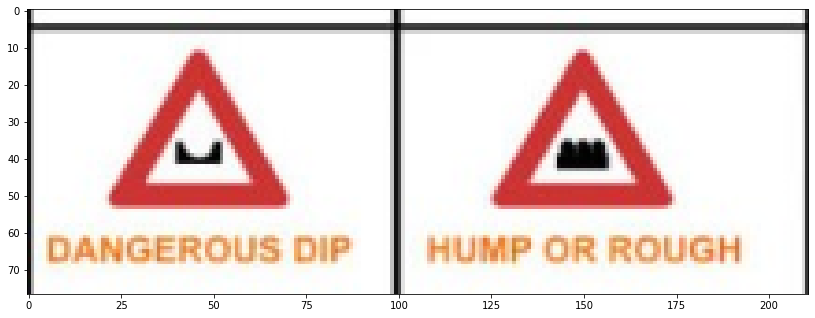

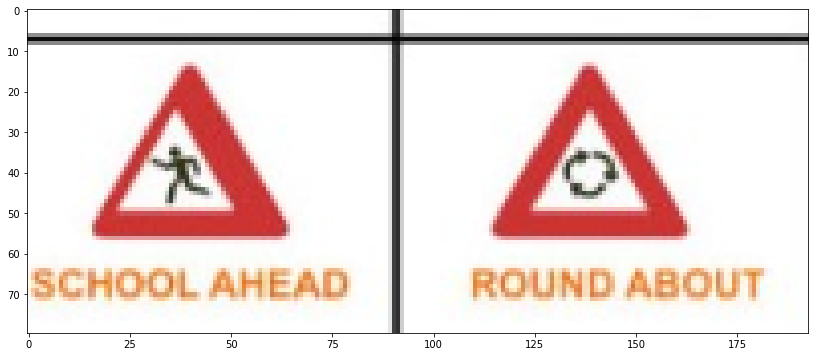

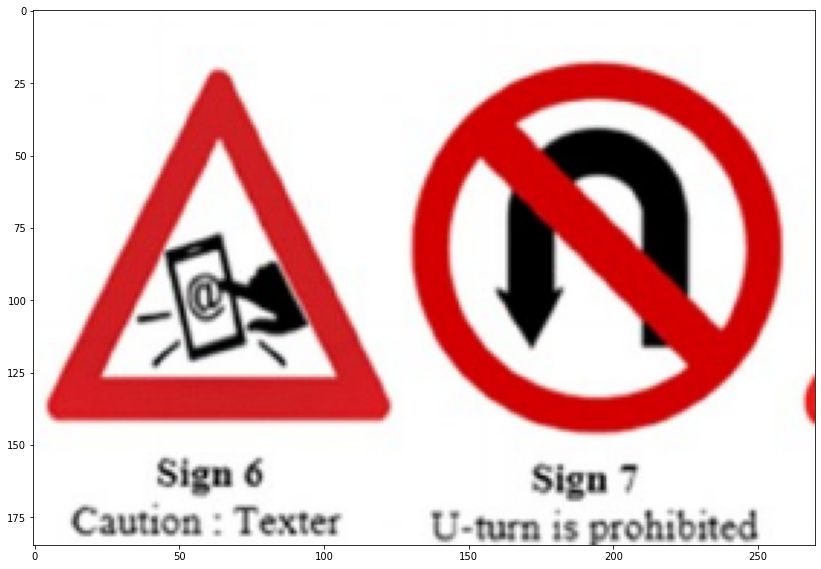

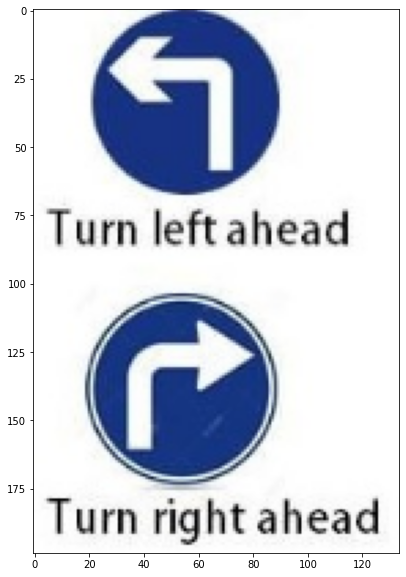

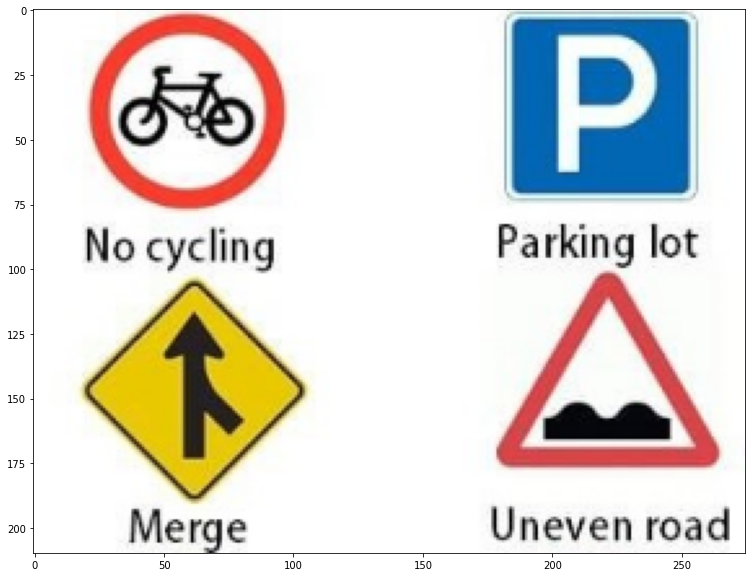

In [ ]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('trafficsignals/test')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=trafficsignals_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>